In [94]:
from super_gradients.training import models
import cv2
import sys
sys.path.append('..')
from anns import Detection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans


In [12]:
%load_ext autoreload
%autoreload 2

In [153]:
CLASSES = [
    "1",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "c",
]
NUM_CLASES = len(CLASSES)

In [154]:
model = models.get("yolo_nas_l",
                        num_classes=NUM_CLASES,
                        checkpoint_path="/home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FIELD_HOMOGRAPHY/ckpt_best.pth")

[2023-09-28 23:06:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FIELD_HOMOGRAPHY/ckpt_best.pth EMA checkpoint.


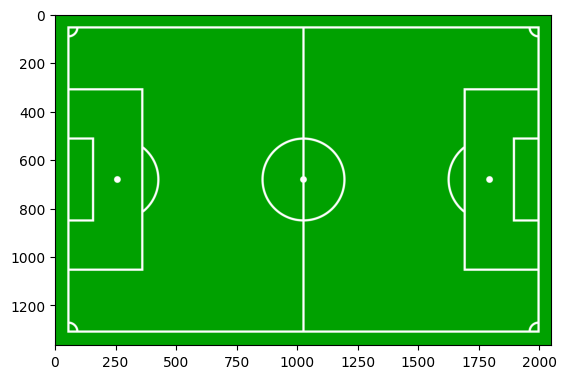

In [155]:
img = cv2.cvtColor(cv2.imread('frame.png'), cv2.COLOR_BGR2RGB)
field = cv2.cvtColor(cv2.imread('field_2d.jpg'), cv2.COLOR_BGR2RGB)


plt.imshow(field)

In [156]:
results = list(model.predict(img, conf=0.25))[0]
detections = Detection.from_yoloNas(pred=results)

[2023-09-28 23:06:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


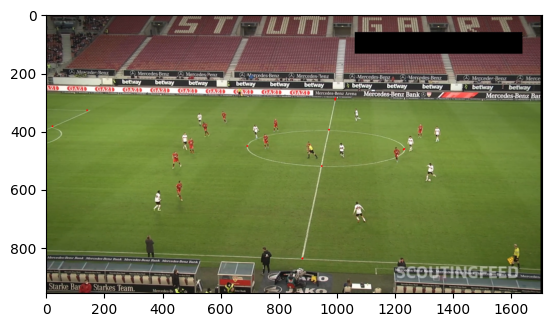

In [157]:
field = cv2.cvtColor(cv2.imread('field_2d.jpg'), cv2.COLOR_BGR2RGB)

points = img.copy()

for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points = cv2.circle(points, center, 3, (255, 0, 0), -1)


plt.imshow(points)

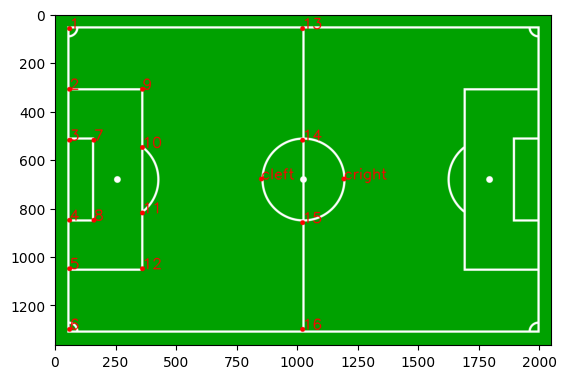

In [160]:
POINT2POINT2D = {
    "1" : (60, 60),
    "2" : (60,310),
    "3" : (60,520),
    "4" : (60,850),
    "5" : (60,1050),
    "6" : (60,1300),
    "7" : (160,520),
    "8" : (160,850),
    "9" : (360,310),
    "10" : (360,550),
    "11" : (360,820),
    "12" : (360,1050),
    "13": (1020,60),
    "14" : (1020,520),
    "15" : (1020,860),
    "16" : (1020,1300),
    "cright" : (1190,680),
    "cleft" : (850,680),
}

check = field.copy()

for id_, coord in POINT2POINT2D.items():
    check = cv2.circle(check, coord, 10, (255, 0, 0), -1)
    check = cv2.putText(check, id_, coord, cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0),3)

plt.imshow(check)

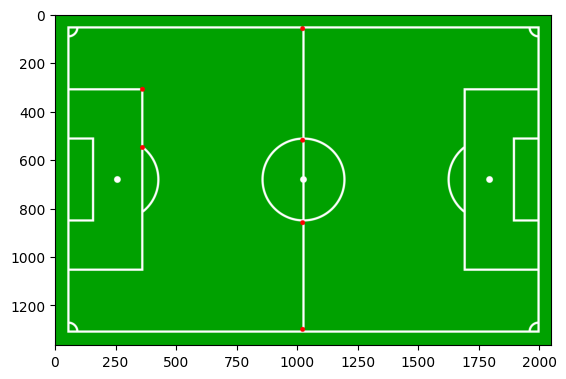

In [161]:
src_points = []
dst_points = []


anns_2d = field.copy()


for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    if str(detection.class_name) in POINT2POINT2D:
        points_2d = POINT2POINT2D[str(detection.class_name)]
        src_points.append(center)
        dst_points.append(points_2d)
        anns_2d = cv2.circle(anns_2d,points_2d, 10, (255, 0, 0), -1)


plt.imshow(anns_2d)

In [162]:
H, status = cv2.findHomography(np.array(src_points), np.array(dst_points))


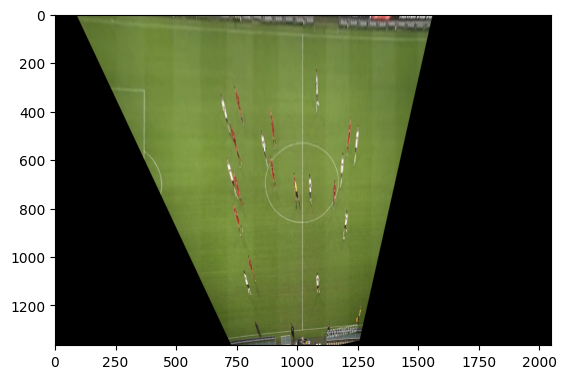

In [163]:
im_out = cv2.warpPerspective(img, H, (field.shape[1],field.shape[0]))
plt.imshow(im_out)

In [164]:
BALL = (1035, 400)
ball_pts = np.array([BALL],np.float32).reshape(-1,1,2)

In [165]:
from mask_utils import get_perspective_transform

In [166]:
pred_homo = get_perspective_transform(np.array(src_points),np.array(dst_points))

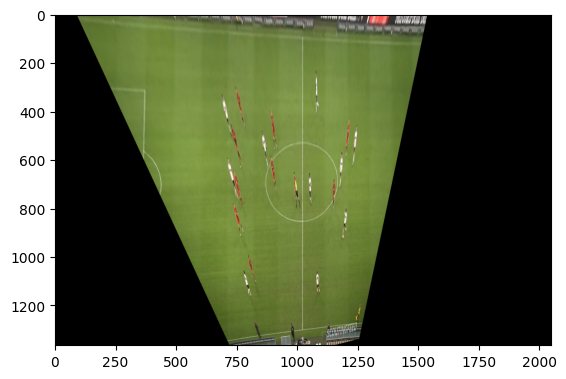

In [167]:
im_out = cv2.warpPerspective(img, pred_homo, (field.shape[1],field.shape[0]))
plt.imshow(im_out)

In [168]:
ball_pts_2d = cv2.perspectiveTransform(ball_pts,pred_homo)
ball_pts_2d = ball_pts_2d.astype(int)

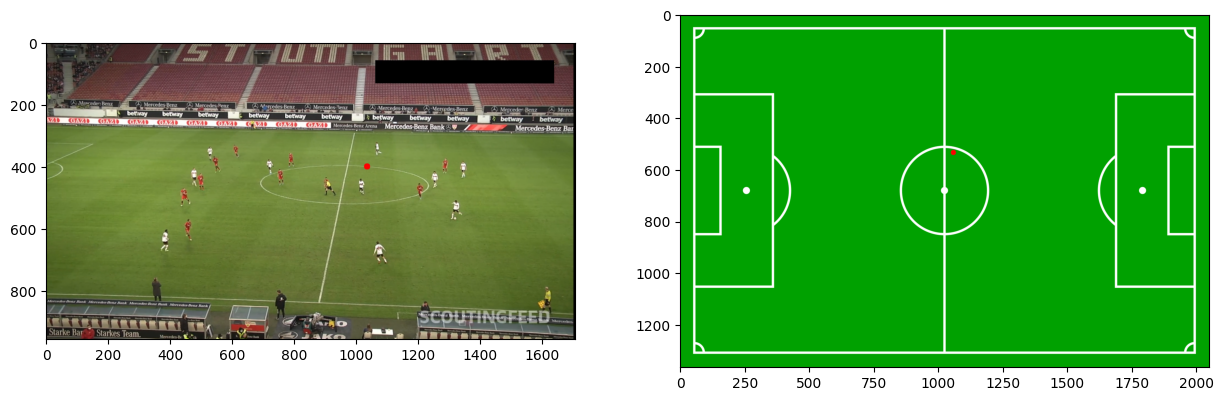

In [169]:
ball = img.copy()
ball = cv2.circle(ball, BALL, 10, (255, 0, 0), -1)

ball_2d = field.copy()
ball_2d = cv2.circle(ball_2d, tuple(ball_pts_2d[0][0]), 10, (255, 0, 0), -1)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(ball)
ax[1].imshow(ball_2d)

# CHECK ORIENTATION OF FIELD

In [142]:
detection

Detection(rect=Rect(x=1213.33203125, y=441.4552307128906, width=35.5125732421875, height=41.610992431640625), class_id=16, class_name='c', confidence=0.2993531823158264, tracker_id=None, color=None)

In [143]:
keypoints_found = {}
centers_found = []

for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple

    if detection.class_name == 'c':
        centers_found.append(detection)
    else:
        if detection.class_name not in keypoints_found:
            keypoints_found[detection.class_name] = detection
        else:
            if keypoints_found[detection.class_name].confidence < detection.confidence:
                keypoints_found[detection.class_name] = detection


center_points = []

for center in centers_found:
    x2, y2 = center.rect.bottom_right.int_xy_tuple
    x1, y1 = center.rect.top_left.int_xy_tuple

    # get center of x1,y1 x2,y2
    center_point = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    center_points.append(center_point)

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
kmeans.fit(center_points)
sides = {}

if kmeans.cluster_centers_[0][0] < kmeans.cluster_centers_[1][0]:
    sides[0] = 'left'
    sides[1] = 'right'
else:
    sides[0] = 'right'
    sides[1] = 'left'


left_centers = []
right_centers = []

for center in centers_found:
    x2, y2 = center.rect.bottom_right.int_xy_tuple
    x1, y1 = center.rect.top_left.int_xy_tuple

    center_point = (int((x1 + x2) / 2),int((y1 + y2) / 2))

    if sides[kmeans.predict([center_point])[0]] == 'left':
        left_centers.append(center)
    else:
        right_centers.append(center)

higher_left_conf = -1
higher_left_conf_center = None

for left_center in left_centers:
    if left_center.confidence > higher_left_conf:
        higher_left_conf_center = left_center
        higher_left_conf = left_center.confidence


keypoints_found['cleft'] = higher_left_conf_center

higher_right_conf = -1
higher_right_conf_center = None

for right_center in right_centers:
    if right_center.confidence > higher_right_conf:
        higher_right_conf_center = right_center
        higher_right_conf = right_center.confidence


keypoints_found['cright'] = higher_left_conf_center


In [147]:
keypoints_found

{'15': Detection(rect=Rect(x=930.8433227539062, y=497.3390197753906, width=35.24053955078125, height=45.022735595703125), class_id=6, class_name='15', confidence=0.7331376671791077, tracker_id=None, color=None),
 '14': Detection(rect=Rect(x=960.1361694335938, y=380.1929626464844, width=26.93023681640625, height=29.725555419921875), class_id=5, class_name='14', confidence=0.7095667123794556, tracker_id=None, color=None),
 '9': Detection(rect=Rect(x=130.5150146484375, y=314.9879150390625, width=22.49627685546875, height=25.240966796875), class_id=15, class_name='9', confidence=0.6588558554649353, tracker_id=None, color=None),
 '16': Detection(rect=Rect(x=864.5060424804688, y=819.5475463867188, width=35.33929443359375, height=36.4150390625), class_id=7, class_name='16', confidence=0.6375082731246948, tracker_id=None, color=None),
 '13': Detection(rect=Rect(x=985.9769897460938, y=281.0638122558594, width=17.998779296875, height=20.50848388671875), class_id=4, class_name='13', confidence=0.

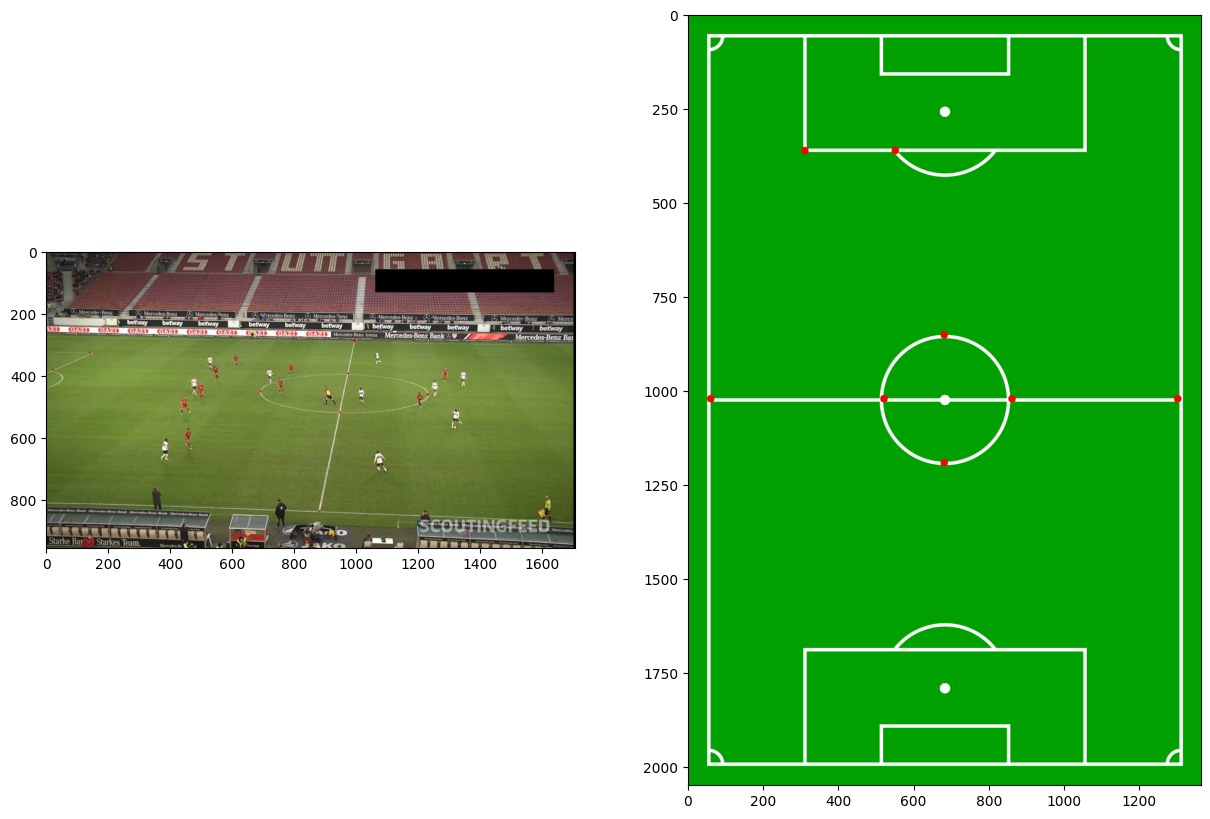

In [152]:

anns_2d = field.copy()


for class_str,detection in keypoints_found.items():
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    if class_str in POINT2POINT2D:
        points_2d = POINT2POINT2D[class_str]
        src_points.append(center)
        dst_points.append(points_2d)
        anns_2d = cv2.circle(anns_2d,points_2d, 10, (255, 0, 0), -1)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(points)
ax[1].imshow(anns_2d)
